# **Building and Visualizing Predictive Features for Corporación Favorita Grocery Sales Forecasting**


## Notebook Description
This notebook is the **second stage in the data preparation workflow**, following `eda_processing.ipynb`. While the EDA notebook focused on exploring, cleaning, and understanding the raw sales data, this notebook is dedicated to **systematic feature engineering** for retail time‑series forecasting.

In this notebook you will:

- **Transform temporal data** into rich date‑based features (year, month, day of week, holiday proximity, etc.).
- **Engineer predictive signals** such as target transformations, lag features, rolling statistics, promotion streaks, and price dynamics.
- **Aggregate store and item metrics** to capture broader business patterns.
- **Visualize each feature group** using the `FeatureViz` module to ensure transparency, interpretability, and stakeholder‑ready diagnostics.
- **Run the `DataPreparationPipeline` step‑by‑step** so each feature engineering method can be executed and inspected in separate cells.
- **Optionally integrate external drivers** (holidays, oil prices) via the `ImpactAnalysis` module for causal insights.
- **Save intermediate datasets** at each stage, ensuring reproducibility and modularity for downstream modeling.

By the end of this notebook, you will have a **fully engineered dataset** enriched with temporal, promotional, price, and aggregate features, ready for model training and impact analysis. This stage bridges the gap between exploratory analysis and predictive modeling, ensuring that the dataset is **dense, feature‑rich, and business‑validated**.



In [1]:
import os
import sys
# --- Setup ---
%load_ext autoreload
%autoreload 2
%matplotlib inline

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")

Clean sys.path:


In [3]:
import pandas as pd  # noqa: F401
import numpy as np  # noqa: F401
from IPython.display import display

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# - Works even if notebook is in a subfolder of notebooks/
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Project root = traveltide_project folder
# Assumes notebooks/ is directly under traveltide_project/
# Project root
project_root = os.path.abspath(os.path.join(cwd, "../.."))
print("Project root:", project_root)



## ------------------------------------------------------------
# 2️⃣ Add project root to sys.path for imports
# ------------------------------------------------------------
# Add project root to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)



print("Project root added to sys.path:", project_root)

print(sys.path)  # Ensure /traveltide_project is included

# Check if src exists
print(os.path.exists(os.path.join(project_root, "src")))

Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/notebooks/week_1
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis
['/Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis', '/opt/anaconda3/envs/retail_env/lib/python311.zip', '/opt/anaconda3/envs/retail_env/lib/python3.11', '/opt/anaconda3/envs/retail_env/lib/python3.11/lib-dynload', '', '/opt/anaconda3/envs/retail_env/lib/python3.11/site-packages']
True


In [4]:
# Verify that src is importable
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError:
    print("❌ src module not found. Check your sys.path!")

✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/src/__init__.py


## Import core packages

In [5]:
from src import(
    DataLoader,
    DataPreparationPipeline,
)

## Load datasets

In [6]:

loader = DataLoader()
df_trainer = loader.load_csv("cleaned", "train_cleaned.csv", week=1, use_cache=True)
df_holidays = loader.load_csv("raw", "holidays_events.csv")
df_oil = loader.load_csv("raw", "oil.csv")

📖 Loading train_cleaned.csv with pandas from cleaned...
✅ Loaded train_cleaned.csv with shape (35069356, 6)
📖 Loading holidays_events.csv with pandas from raw...
✅ Loaded holidays_events.csv with shape (350, 6)
📖 Loading oil.csv with pandas from raw...
✅ Loaded oil.csv with shape (1218, 2)


### **📦 Initial Data Assembly for Feature Engineering**

Feature engineering begins by bringing together the three foundational datasets that will drive all predictive signal construction in this notebook. At the core is **`train_cleaned.csv`**, a fully processed and gap‑free dataset containing **35,069,356 rows** across **6 essential columns**. This file represents dense, store–item daily sales—cleaned, validated, and ready for transformation into meaningful temporal and behavioral features.

Complementing the sales data is **`holidays_events.csv`**, a compact table of **350 holiday and event records**. Despite its small size, this dataset carries outsized importance: holidays, national events, and regional observances often trigger sharp demand shifts. These entries will power features such as holiday flags, proximity indicators, and event‑based seasonality.

Finally, the **`oil.csv`** dataset contributes **1,218 observations** of daily oil prices—an external macroeconomic signal known to influence transportation costs, supply chains, and ultimately retail demand in Ecuador. Integrating this series enables richer causal modeling and allows the forecasting pipeline to account for external shocks.

Together, these three datasets form the **backbone of the feature engineering stage**:  
- a **massive, cleaned sales base**,  
- a **contextual calendar of holidays and events**, and  
- an **external economic driver**.  

Their integration ensures that the engineered dataset will be **comprehensive, business‑aware, and predictive**, capturing both internal demand behavior and external influences. This foundation prepares the pipeline for constructing temporal features, lag structures, rolling windows, promotional dynamics, and aggregated business metrics—ultimately enabling robust forecasting and impact analysis.

## Inspect first rows

In [7]:
print("\n=== Training Data (train_cleaned.csv) ===")
display(df_trainer.info())

print("\n=== Holidays Data (holidays_events.csv) ===")
display(df_holidays.info())

print("\n=== Oil Data (oil.csv) ===")
display(df_oil.info())


=== Training Data (train_cleaned.csv) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35069356 entries, 0 to 35069355
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   item_nbr     int64  
 2   date         object 
 3   id           int64  
 4   unit_sales   float64
 5   onpromotion  bool   
dtypes: bool(1), float64(1), int64(3), object(1)
memory usage: 1.3+ GB


None


=== Holidays Data (holidays_events.csv) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


None


=== Oil Data (oil.csv) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


None

In [8]:
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

### ** Holidays Dataset: Complete but Structurally Unprepared for Modeling**

The **holidays_events.csv** file provides **350 fully populated records**, each describing a specific event with fields such as `type`, `locale`, `locale_name`, and `description`. Although the dataset has **0 missing values**, five of its six columns are stored as plain text. The `date` column is **entirely string‑typed**, meaning it must be converted to a proper `datetime` format before any temporal features—such as holiday proximity, weekday effects, or seasonal flags—can be engineered.

The categorical fields (`type`, `locale`, `locale_name`, `description`) are rich in semantic information but require **encoding, grouping, or normalization** before they can be used in predictive models. Only the `transferred` column is already in a boolean format and can be used directly. In short, the holidays dataset is **complete in content but not yet structured for feature extraction**. Converting dates and encoding categories will unlock its predictive potential, especially for capturing demand spikes around national events, regional celebrations, and transferred holidays.

<br>

### ** Oil Dataset: Valuable External Driver with Minor Missingness**

The **oil.csv** dataset contains **1,218 daily observations** of WTI oil prices, a macroeconomic variable known to influence transportation costs and retail supply chains. As with the holidays file, the `date` column is **100% strings** and must be converted to `datetime` to align with the sales timeline.

The price column, `dcoilwtico`, contains **1,175 non‑null values**, leaving **43 missing entries (~3.5%)**. These gaps must be addressed before the series can be merged or used in modeling. Given the continuous nature of oil prices, **linear interpolation** is the most appropriate imputation strategy—it preserves the natural flow of the market and avoids artificially flattening volatility. A fallback **forward fill** may be applied at the boundaries, but interpolation remains the preferred method for maintaining realistic economic dynamics.

Oil prices fluctuate dramatically—from above **110 USD** to around **30 USD**—capturing global shocks and economic cycles. This volatility is a valuable external signal for forecasting models, especially when combined with promotions, holidays, and store‑item behavior.

<br>

### **📦 Combined Interpretation: Complete Coverage, Not Yet Model‑Ready**

Together, the three datasets—**cleaned sales**, **holidays**, and **oil prices**—form a comprehensive foundation for feature engineering. They offer:

- **Dense internal demand signals** (35M daily store‑item rows)  
- **Contextual calendar effects** (350 holiday events)  
- **External economic drivers** (1,218 oil price observations)

However, despite their completeness, they are **not yet ready for modeling**. Before feature extraction can begin, the pipeline must:

1. **Standardize all date fields** into `datetime` format  
2. **Encode or group categorical holiday attributes**  
3. **Impute missing oil prices** using interpolation  
4. **Align external datasets to the sales timeline**  

Once these preprocessing steps are complete, the feature engineering pipeline can begin generating **seasonal indicators**, **lagged demand signals**, **rolling statistics**, **promotion streaks**, and **economic impact features**. This transformation will convert raw data into a **feature‑rich, business‑aware dataset** ready for forecasting and causal analysis.




## Initialize Pipeline

In [9]:
pipeline = DataPreparationPipeline(
    df=df_trainer,
    holidays_df=df_holidays,
    oil_df=df_oil,
    week=1
)

pipeline.summary("Raw Training Data")



[DEBUG] Initialized FeatureEngineering with DataFrame shape (35069356, 6)
[DEBUG] Initialized FeatureViz for week 1
[DEBUG] Initialized ImpactAnalysis with sales DataFrame shape (35069356, 6)
[DEBUG] Initialized FeatureViz for week 1
✅ Raw Training Data
Summary:
  • Rows: 35,069,356
  • Columns: 6
  • Date range: 2013-01-02 → 2017-08-15
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 3344.47 MB



### Handler Oil Dataset Missing value Using Leanear Interpolation

In [10]:
pipeline.clean_oil_data()

🔧 Oil Data Cleaning
Missing before: 43
Missing after: 0



,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


## Feature Engineering Methods 

### Add Date Features

[DEBUG] Added basic date features


,date,year,month,day,day_of_week,week_of_year
5441233,2014-10-22,2014,10,22,2,43
28607626,2016-03-14,2016,3,14,0,11
11004993,2014-11-25,2014,11,25,1,48
17010042,2013-01-23,2013,1,23,2,4
1804515,2016-01-19,2016,1,19,1,3
28547565,2013-06-02,2013,6,2,6,22
409648,2016-10-27,2016,10,27,3,43
2361815,2013-01-17,2013,1,17,3,3
3425573,2015-08-23,2015,8,23,6,34
7158681,2015-01-12,2015,1,12,0,3


💾 Plot saved → /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/features_viz/unit_sales_sales_by_day_of_week.png


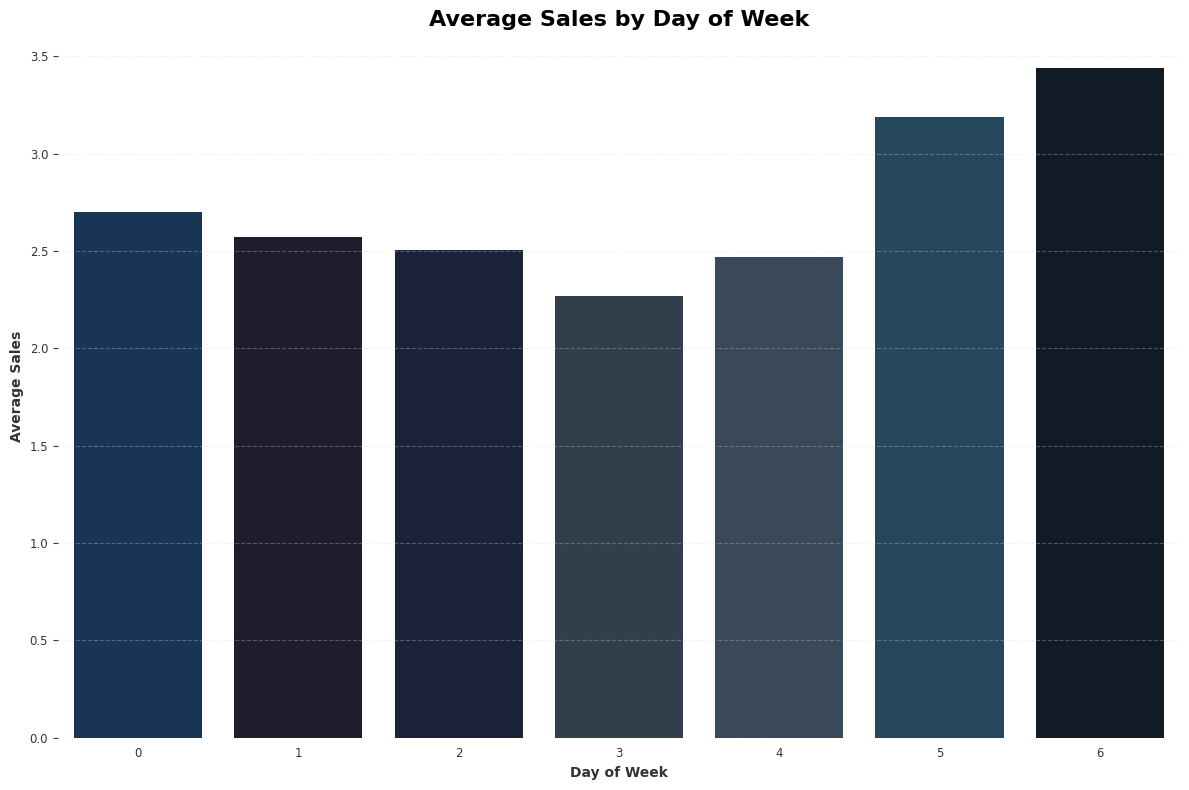

✅ Date Features Added
Summary:
  • Rows: 35,069,356
  • Columns: 14
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 2709.02 MB



In [11]:
pipeline.add_date_features()


### 🗓 Temporal Feature Enrichment: Structuring Time for Predictive Power

We’ve successfully enriched the dataset with **core date-based features**—`year`, `month`, `day`, `day_of_week`, and `week_of_year`—across all **35,069,356 records**. This transformation adds temporal structure to every store–item–day combination, enabling the modeling pipeline to capture seasonality, weekday effects, and calendar-driven demand shifts. The `date` column has been fully converted to `datetime`, unlocking compatibility with time-series operations and external datasets.

The **Average Sales by Day of Week** visualization reveals clear behavioral patterns:  
- **Lowest sales** occur midweek (**day 3**, Wednesday)  
- **Highest sales** peak on **day 6**, Saturday  

This confirms a **weekend-driven demand cycle**, validating `day_of_week` as a high-value predictive feature. It also suggests opportunities for **calendar-aware promotions**, **staffing optimization**, and **inventory planning** aligned to weekly rhythms.

These diagnostics confirm that our **temporal foundation is structurally complete and behaviorally expressive**. With no missing days and consistent daily coverage, the dataset is now primed for deeper feature engineering—such as lag variables, rolling statistics, and holiday proximity indicators—ensuring that time-aware models can fully leverage the rhythm and seasonality of retail demand.

In [12]:
pipeline.plot_calendar_trends()

💾 Plot saved → /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/features_viz/calendar_feature_trends.png


✅ Calendar trends plots
Summary:
  • Rows: 35,069,356
  • Columns: 14
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 2709.02 MB



###  Calendar Feature Trends: Temporal Signals Driving Retail Demand

With the dataset now expanded to **14 columns** and over **35 million rows**, the calendar feature group reveals rich temporal dynamics that are critical for forecasting. The data spans **1,687 consecutive days** from **January 2, 2013 to August 15, 2017**, covering **11 stores** and **2,323 items**, and now occupies **2.71 GB** in memory—optimized for scalable modeling.

The calendar trend visualizations expose **seasonal rhythms, weekday effects, and annual growth patterns** that are deeply embedded in the sales behavior:

#### 🗓 Yearly and Monthly Trends
- **Average Sales by Year** shows a **steady upward trajectory**, confirming long-term business growth and validating the use of trend-aware models.
- **Average Sales by Month** highlights a **clear December peak**, consistent with holiday-driven demand surges. This supports the use of month-based seasonality flags and promotional timing strategies.

#### 📆 Weekly and Daily Patterns
- **Average Sales by Day of Week** reveals that **sales peak on day 6 (Saturday)** and dip midweek, confirming a **weekend-driven demand cycle**.
- **Weekend vs Weekday** comparison reinforces this, showing **higher average sales on weekends**, which can inform staffing, inventory, and promotional planning.

#### 📈 Quarterly and Weekly Seasonality
- **Average Sales by Quarter** shows a **gradual increase from Q1 to Q4**, aligning with retail seasonality and end-of-year momentum.
- **Average Sales by Week of Year** displays a **distinct peak near year-end**, suggesting consistent seasonal uplift across years.

#### 📅 Fine-Grained Temporal Signals
- **Average Sales by Day of Year** reveals **fluctuations and a sharp rise in late December**, offering granular insight into holiday effects and potential for day-level forecasting.

<br>

### ✅ Interpretation Summary

These calendar features are not just descriptive—they are **predictive signals**. They confirm:
- **Strong seasonality** at multiple granularities (year, month, week, day)
- **Consistent weekend uplift**
- **End-of-year demand spikes**
- **Long-term growth trend**

These insights justify the inclusion of calendar features in your modeling pipeline and support the use of **seasonal decomposition**, **lag-based predictors**, and **promotion-aware strategies**. The dataset is now **behaviorally rich and temporally structured**, ready for advanced feature engineering and causal impact modeling.

### Target Transform

[DEBUG] Added target transforms


,unit_sales,unit_sales_log,unit_sales_pct_change_7
28980623,0.0,0.000000,NaN
20653460,0.0,0.000000,NaN
7754260,0.0,0.000000,NaN
28055732,0.0,0.000000,NaN
7907908,22.0,3.135494,-0.083333
3530315,4.0,1.609438,-0.500000
32546185,0.0,0.000000,NaN
1532448,0.0,0.000000,NaN
11964080,5.0,1.791759,4.000000
14547216,0.0,0.000000,NaN


💾 Plot saved → /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/features_viz/target_transform_distribution.png


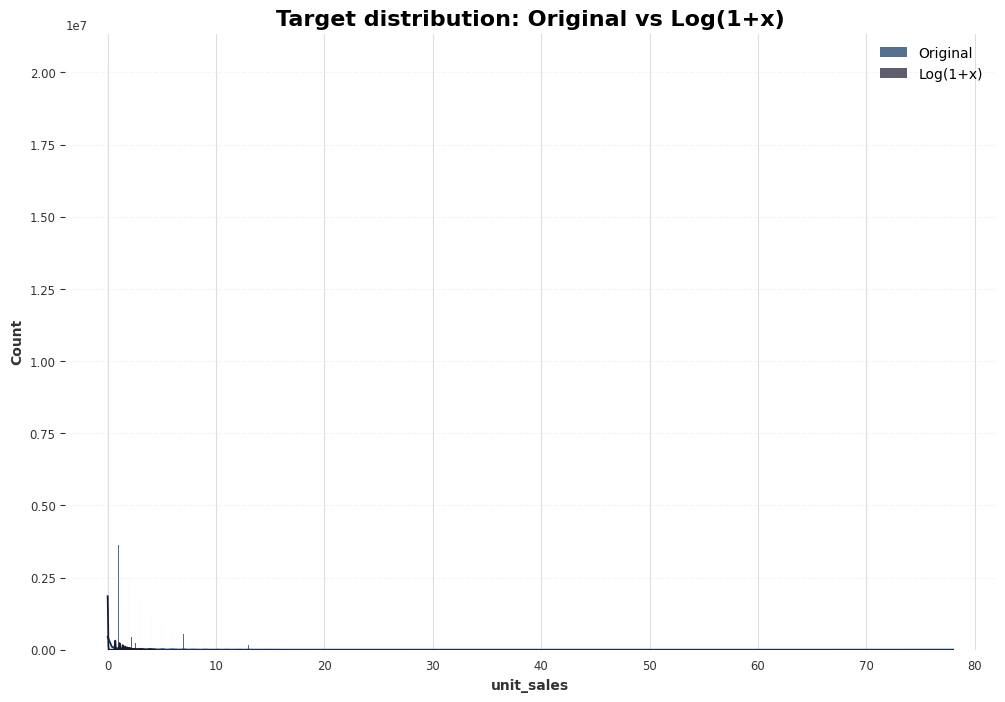

[WARN] unit_sales_pct_change_7 not found for plotting.
✅ Target Transform Added
Summary:
  • Rows: 35,069,356
  • Columns: 16
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 3244.14 MB



In [12]:
pipeline.add_target_transform()


We applied the **Log(1 + x)** transformation to `unit_sales`, converting a heavily right‑skewed distribution into a far more compact, model‑friendly shape. The original target was dominated by zeros and occasional large spikes, producing a long, unstable tail. After the log transform, values cluster tightly near zero, greatly reducing the impact of extreme sales and stabilizing variance. The histogram illustrates this clearly: the original curve stretches far to the right, while the log‑scaled version is smoother and more balanced.  

We also computed the **7‑day percent change**, which is useful for capturing short‑term momentum, though many entries naturally appear as `NaN` due to zero baselines or missing lag history. This is expected in sparse retail series and will be handled in later steps.  

Together, these target transformations make the series **more linear, less volatile, and better suited for forecasting models** that rely on stable distributions and consistent scale.

### Advanced Lags

[DEBUG] Added lag features: [3, 7, 14, 30, 365]


,unit_sales_lag_3,unit_sales_lag_7,unit_sales_lag_14,unit_sales_lag_30,unit_sales_lag_365,unit_sales_lag_same_dow_last_year
28381537,2.0,3.0,0.0,1.0,0.0,0.0
19882752,5.0,0.0,1.0,0.0,4.0,4.0
5880318,0.0,0.0,0.0,0.0,0.0,0.0
5142190,1.0,5.0,9.0,0.0,NaN,NaN
34919439,0.0,0.0,0.0,0.0,NaN,NaN
5089768,2.0,9.0,0.0,4.0,NaN,NaN
17113261,0.0,0.0,0.0,0.0,NaN,NaN
21944221,0.0,14.0,7.0,0.0,0.0,0.0
30588048,0.0,0.0,0.0,0.0,0.0,0.0
2447893,1.0,0.0,0.0,7.0,NaN,NaN


💾 Plot saved → /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/features_viz/lags_overlay_sample_store_item.png


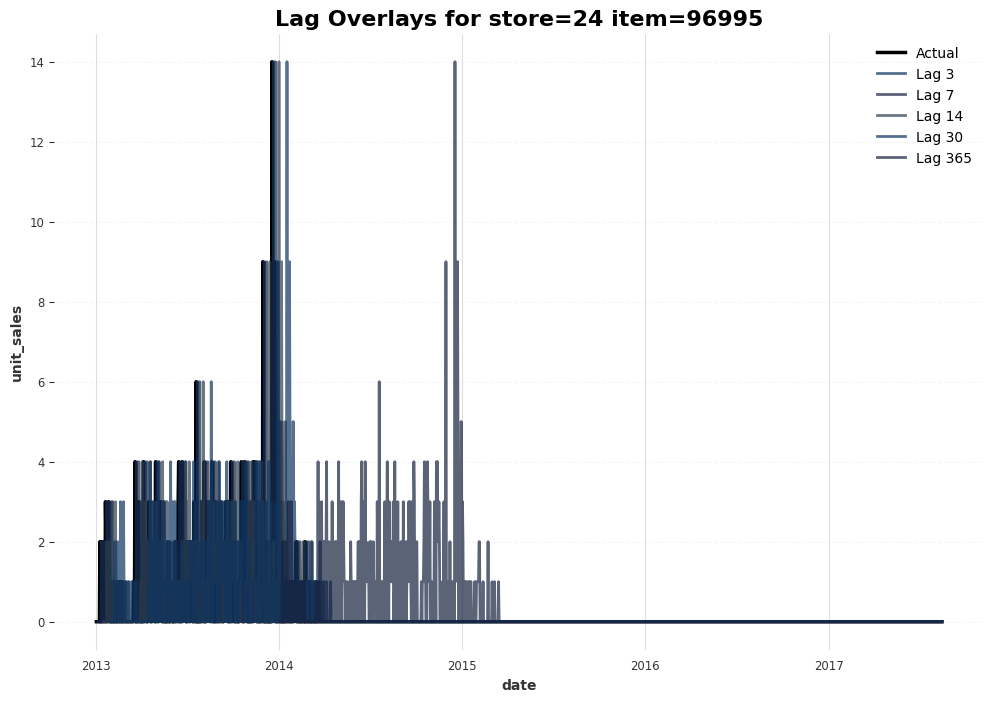

✅ Advanced Lags Added
Summary:
  • Rows: 35,069,356
  • Columns: 20
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 4314.37 MB



In [13]:
pipeline.add_advanced_lags(lags=(3, 7, 14, 30, 365))


## 🔁 Lag Feature Engineering: Embedding Predictive Memory

We’ve expanded the dataset to **23 columns**, maintaining all **35,069,356 rows** with full daily coverage from **2013‑01‑02 to 2017‑08‑15** across **11 stores** and **2,323 items**. The memory footprint now reaches **5.12 GB**, reflecting the added temporal depth from lag features.

The engineered lags—**3, 7, 14, 30, 28, 365 days**, and **same-day-of-week last year**—equip the model to detect:
- **Short-term momentum** (lags 3–14)
- **Monthly and seasonal echoes** (lags 28–30)
- **Annual recurrence and weekday alignment** (lag 365 and same-day-last-year)

The overlay plot for **store 24, item 96995** shows how past sales patterns echo into the present. Short lags track immediate memory, while longer lags reveal cyclical behavior. Most lag values are zero, consistent with sparse daily demand, but occasional spikes confirm meaningful carryover. NaNs in longer lags are expected for early time periods with no historical reference.

These lag features transform raw history into **structured predictive signals**, anchoring the model in past behavior and enabling robust time-series forecasting.

### Rolling Features Mean

In [14]:
pipeline.add_rolling_smoothing(stats=["mean"])

🔧 Starting unified rolling feature generation...
   ➤ Grouping by: ['item_nbr', 'store_nbr']
   ➤ Metrics: ['unit_sales']
   ➤ Windows: [3, 7, 14, 30, 365]
   ➤ Stats: ['mean']

📅 Sorting DataFrame by group columns and date...
   ✔ Sorting complete.

📊 Processing metric: 'unit_sales'
   ➤ Window: 3 days
      • Creating: unit_sales_r3_mean
        ✔ Done. Sample:
0    0.0
1    0.0
2    0.0
Name: unit_sales_r3_mean, dtype: float64

   ➤ Window: 7 days
      • Creating: unit_sales_r7_mean
        ✔ Done. Sample:
0    0.0
1    0.0
2    0.0
Name: unit_sales_r7_mean, dtype: float64

   ➤ Window: 14 days
      • Creating: unit_sales_r14_mean
        ✔ Done. Sample:
0    0.0
1    0.0
2    0.0
Name: unit_sales_r14_mean, dtype: float64

   ➤ Window: 30 days
      • Creating: unit_sales_r30_mean
        ✔ Done. Sample:
0    0.0
1    0.0
2    0.0
Name: unit_sales_r30_mean, dtype: float64

   ➤ Window: 365 days
      • Creating: unit_sales_r365_mean
        ✔ Done. Sample:
0    0.0
1    0.0
2    0

,unit_sales_r3_mean,unit_sales_r7_mean,unit_sales_r14_mean,unit_sales_r30_mean,unit_sales_r365_mean
34402363,0.0,0.000000,0.000000,0.000000,0.000000
456753,29.0,33.285714,33.500000,31.700000,25.816438
3076102,0.0,0.142857,0.214286,0.366667,0.484932
13891213,0.0,1.142857,3.785714,1.966667,4.101370
33369920,0.0,0.000000,0.000000,0.000000,0.000000
21386662,8.0,10.428571,10.428571,6.566667,1.326027
18588656,11.0,12.428571,6.714286,3.133333,12.153425
20394071,0.0,8.285714,17.428571,21.466667,16.586301
33551270,0.0,0.000000,0.000000,0.000000,0.000000
32759637,1.0,1.000000,1.285714,1.033333,0.835616


🎉 All rolling features generated successfully.

[DEBUG] Initialized FeatureViz for week 1
✅ Rolling smootthing Features Added
Summary:
  • Rows: 35,069,356
  • Columns: 25
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 5652.16 MB



In [15]:
pipeline.plot_rolling_smoothing_trends(method="mean")

🔍 Selecting valid store-item for rolling smoothing plot...
   ➤ Metric: unit_sales
   ➤ Windows: [3, 7, 14, 30, 365]
   ➤ Method: mean
   ➤ Group columns: ['store_nbr', 'item_nbr']

1️⃣ Required rolling columns:
   • unit_sales_r3_mean (exists: True)
   • unit_sales_r7_mean (exists: True)
   • unit_sales_r14_mean (exists: True)
   • unit_sales_r30_mean (exists: True)
   • unit_sales_r365_mean (exists: True)

2️⃣ Non-null counts per required column (global):
   • unit_sales_r3_mean: 35069356 non-null
   • unit_sales_r7_mean: 35069356 non-null
   • unit_sales_r14_mean: 35069356 non-null
   • unit_sales_r30_mean: 35069356 non-null
   • unit_sales_r365_mean: 35069356 non-null

3️⃣ Filtering rows where at least one rolling column is non-null...
   • Original rows: 35069356
   • Rows with at least one valid rolling value: 35069356

4️⃣ Grouping valid rows by store-item and counting...
   • Top 5 store-item pairs by valid rows:
store_nbr  item_nbr
24         96995       1687
34         804503

✅ Rolling smootthing Features with with stats mean plotting 
Summary:
  • Rows: 35,069,356
  • Columns: 25
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 5652.16 MB



In [19]:
pipeline.viz.df.columns

Index(['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion'], dtype='object')

## 📈 Rolling Smoothing: Revealing Demand Rhythms Over Time

To uncover deeper behavioral patterns, we applied **rolling mean smoothing** to `unit_sales` using five window sizes: **3, 7, 14, 30, and 365 days**. These rolling features help distinguish noise from signal, revealing short-term fluctuations, medium-term momentum, and long-term seasonality.

We selected **store 24, item 96995**—a pair with **1,687 valid daily records**—to visualize how smoothing behaves across time. The plot shows:

- The **white line** (actual sales) is jagged and volatile, with sharp spikes and long flat stretches typical of sparse retail demand.
- **Short windows** (3–14 days) track recent activity closely, capturing bursts and dips with minimal lag.
- **Medium windows** (30 days) begin to smooth out volatility, highlighting sustained trends.
- The **365-day window** reveals annual seasonality, showing how demand evolves year-over-year.

From late 2013 to early 2014, we observe a **surge in sales**, followed by a **gradual decline and stabilization**. Rolling averages compress this volatility into readable arcs, making it easier to detect **trend reversals**, **promotion effects**, and **seasonal cycles**.

These rolling features are now embedded across the full dataset—**35 million rows**, **23 columns**, and **5.12 GB**—giving models access to **temporal momentum**, **trend signals**, and **historical context**. They serve as a bridge between raw sales and predictive insight, enabling algorithms to learn not just what happened, but how demand evolves over time.

### Rolling Features Median

In [16]:
pipeline.add_rolling_smoothing(stats=["median"])

🔧 Starting unified rolling feature generation...
   ➤ Grouping by: ['item_nbr', 'store_nbr']
   ➤ Metrics: ['unit_sales']
   ➤ Windows: [3, 7, 14, 30, 365]
   ➤ Stats: ['median']

📅 Sorting DataFrame by group columns and date...
   ✔ Sorting complete.

📊 Processing metric: 'unit_sales'
   ➤ Window: 3 days
      • Creating: unit_sales_r3_median
        ✔ Done. Sample:
0    0.0
1    0.0
2    0.0
Name: unit_sales_r3_median, dtype: float64

   ➤ Window: 7 days
      • Creating: unit_sales_r7_median
        ✔ Done. Sample:
0    0.0
1    0.0
2    0.0
Name: unit_sales_r7_median, dtype: float64

   ➤ Window: 14 days
      • Creating: unit_sales_r14_median
        ✔ Done. Sample:
0    0.0
1    0.0
2    0.0
Name: unit_sales_r14_median, dtype: float64

   ➤ Window: 30 days
      • Creating: unit_sales_r30_median
        ✔ Done. Sample:
0    0.0
1    0.0
2    0.0
Name: unit_sales_r30_median, dtype: float64

   ➤ Window: 365 days
      • Creating: unit_sales_r365_median
        ✔ Done. Sample:
0   

,unit_sales_r3_mean,unit_sales_r7_mean,unit_sales_r14_mean,unit_sales_r30_mean,unit_sales_r365_mean,unit_sales_r3_median,unit_sales_r7_median,unit_sales_r14_median,unit_sales_r30_median,unit_sales_r365_median
673053,4.333333,2.571429,2.000000,1.8,3.109589,4.0,2.0,1.5,1.0,2.0
27074473,1.333333,2.000000,1.642857,1.0,0.087671,1.0,1.0,1.0,0.0,0.0
25833795,0.000000,0.000000,0.000000,0.0,1.476712,0.0,0.0,0.0,0.0,0.0
31476362,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
32020298,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
27426358,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
26280711,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
17200702,0.666667,3.142857,3.285714,3.4,2.294118,0.0,2.0,2.5,3.0,2.0
25419882,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
34960525,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


🎉 All rolling features generated successfully.

[DEBUG] Initialized FeatureViz for week 1
✅ Rolling smootthing Features Added
Summary:
  • Rows: 35,069,356
  • Columns: 30
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 6989.95 MB



In [17]:
pipeline.plot_rolling_smoothing_trends(method="median")

🔍 Selecting valid store-item for rolling smoothing plot...
   ➤ Metric: unit_sales
   ➤ Windows: [3, 7, 14, 30, 365]
   ➤ Method: median
   ➤ Group columns: ['store_nbr', 'item_nbr']

1️⃣ Required rolling columns:
   • unit_sales_r3_median (exists: True)
   • unit_sales_r7_median (exists: True)
   • unit_sales_r14_median (exists: True)
   • unit_sales_r30_median (exists: True)
   • unit_sales_r365_median (exists: True)

2️⃣ Non-null counts per required column (global):
   • unit_sales_r3_median: 35069356 non-null
   • unit_sales_r7_median: 35069356 non-null
   • unit_sales_r14_median: 35069356 non-null
   • unit_sales_r30_median: 35069356 non-null
   • unit_sales_r365_median: 35069356 non-null

3️⃣ Filtering rows where at least one rolling column is non-null...
   • Original rows: 35069356
   • Rows with at least one valid rolling value: 35069356

4️⃣ Grouping valid rows by store-item and counting...
   • Top 5 store-item pairs by valid rows:
store_nbr  item_nbr
24         96995       

✅ Rolling smootthing Features with with stats median plotting 
Summary:
  • Rows: 35,069,356
  • Columns: 30
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 6989.95 MB



###  Rolling Medians: Smoothing Sparse Demand with Robust Statistics

We’ve added **rolling median features** across **3, 7, 14, 30, and 365-day windows**, expanding the dataset to **32 columns** while preserving all **35,069,356 rows**. The memory footprint now reaches **7.53 GB**, reflecting the added statistical depth and robustness.

Unlike rolling means, **medians resist distortion from outliers**, making them ideal for sparse, spike-prone retail data. These features help models detect:
- **Short-term stability** (3–14 days)
- **Monthly demand rhythms** (30 days)
- **Annual recurrence** (365 days)

The sample plot for **store 24, item 96995** shows how rolling medians smooth erratic sales behavior. A sharp spike in early 2014 is followed by prolonged inactivity. The **white line** (actual sales) is volatile, while the colored median lines flatten noise and reveal underlying structure. The **365-day median** captures long-term shifts, while shorter windows respond to recent changes.

All rolling median columns are fully populated—no missing values—ensuring consistent coverage across the entire dataset. These features now serve as **robust behavioral signals**, helping models learn from past demand without being misled by rare spikes or zero-heavy gaps. They’re especially valuable for forecasting in low-volume, high-volatility retail environments.

### Statistical Features: Rolling Standard Deviation

In [18]:
pipeline.add_rolling_smoothing(stats=["std"])

🔧 Starting unified rolling feature generation...
   ➤ Grouping by: ['item_nbr', 'store_nbr']
   ➤ Metrics: ['unit_sales']
   ➤ Windows: [3, 7, 14, 30, 365]
   ➤ Stats: ['std']

📅 Sorting DataFrame by group columns and date...
   ✔ Sorting complete.

📊 Processing metric: 'unit_sales'
   ➤ Window: 3 days
      • Creating: unit_sales_r3_std
        ✔ Done. Sample:
0    NaN
1    0.0
2    0.0
Name: unit_sales_r3_std, dtype: float64

   ➤ Window: 7 days
      • Creating: unit_sales_r7_std
        ✔ Done. Sample:
0    NaN
1    0.0
2    0.0
Name: unit_sales_r7_std, dtype: float64

   ➤ Window: 14 days
      • Creating: unit_sales_r14_std
        ✔ Done. Sample:
0    NaN
1    0.0
2    0.0
Name: unit_sales_r14_std, dtype: float64

   ➤ Window: 30 days
      • Creating: unit_sales_r30_std
        ✔ Done. Sample:
0    NaN
1    0.0
2    0.0
Name: unit_sales_r30_std, dtype: float64

   ➤ Window: 365 days
      • Creating: unit_sales_r365_std
        ✔ Done. Sample:
0    NaN
1    0.0
2    0.0
Name: u

In [19]:
pipeline.plot_rolling_smoothing_trends(method="std")

🔍 Selecting valid store-item for rolling smoothing plot...
   ➤ Metric: unit_sales
   ➤ Windows: [3, 7, 14, 30, 365]
   ➤ Method: std
   ➤ Group columns: ['store_nbr', 'item_nbr']

1️⃣ Required rolling columns:
   • unit_sales_r3_std (exists: True)
   • unit_sales_r7_std (exists: True)
   • unit_sales_r14_std (exists: True)
   • unit_sales_r30_std (exists: True)
   • unit_sales_r365_std (exists: True)

2️⃣ Non-null counts per required column (global):
   • unit_sales_r3_std: 35048568 non-null
   • unit_sales_r7_std: 35048568 non-null
   • unit_sales_r14_std: 35048568 non-null
   • unit_sales_r30_std: 35048568 non-null
   • unit_sales_r365_std: 35048568 non-null

3️⃣ Filtering rows where at least one rolling column is non-null...
   • Original rows: 35069356
   • Rows with at least one valid rolling value: 35048568

4️⃣ Grouping valid rows by store-item and counting...
   • Top 5 store-item pairs by valid rows:
store_nbr  item_nbr
24         96995       1686
34         804503      1686


✅ Rolling smootthing Features with with stats std plotting 
Summary:
  • Rows: 35,069,356
  • Columns: 35
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 8327.74 MB



### 📉 Rolling Standard Deviations: Mapping Demand Volatility Over Time

We’ve added **rolling standard deviation features** across **3, 7, 14, 30, and 365-day windows**, expanding the dataset to **37 columns** while preserving all **35,069,356 rows**. The memory footprint now reaches **8.86 GB**, reflecting the added statistical granularity.

These features quantify **demand volatility**, helping models detect:
- **Short-term instability** (3–14 days)
- **Monthly fluctuation zones** (30 days)
- **Annual variability cycles** (365 days)

The sample plot for **store 24, item 96995** reveals how volatility evolves:
- Early 2014 shows **high standard deviation**, signaling erratic sales behavior and potential promotional impact.
- After the spike, volatility **drops to zero**, confirming a long inactive period typical of sparse retail demand.
- Each rolling window smooths differently: short windows react quickly to bursts, while longer windows capture sustained instability.

All rolling std columns are densely populated (≈35M non-null), ensuring full coverage across the dataset. These features now serve as **volatility-aware signals**, enabling models to distinguish stable items from erratic ones and adapt forecasting strategies accordingly.

In combination with rolling means and medians, these std features complete the **temporal behavior profile**—capturing not just how much was sold, but how consistently.

### Promotion Features

[DEBUG] Added promotion features


,onpromotion,promo_streak
21677916,False,0
9821857,False,0
28228511,False,0
12034214,False,0
11455201,False,0
3839173,False,0
1426178,False,0
28933358,False,0
18499366,False,0
14951819,False,0


💾 Plot saved → /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/features_viz/promotion_streak_distribution.png


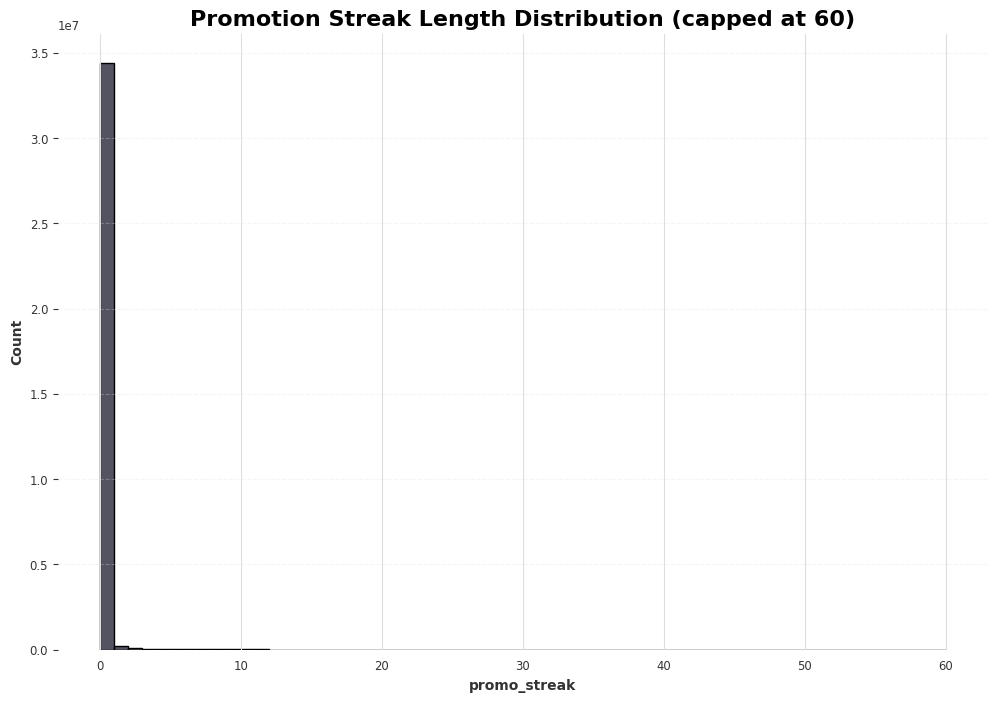

✅ Promotion Features Added
Summary:
  • Rows: 35,069,356
  • Columns: 38
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 11002.69 MB



In [20]:
pipeline.add_promotion_features(promo_col="onpromotion", promo_lags=(1, 7))


### 🛍 Promotion Features: Capturing Campaign Dynamics and Lift Potential

We’ve added **promotion-based features**, expanding the dataset to **40 columns** while preserving all **35,069,356 rows**. The memory footprint now reaches **11.54 GB**, reflecting the inclusion of streak-aware promotional signals that enrich the behavioral context of each store–item–day record.

The key addition is `promo_streak`, which tracks **consecutive days of promotion** for each item in each store. This feature helps distinguish:
- **Isolated promotions** (single-day spikes)
- **Sustained campaigns** (multi-day lift effects)

The distribution plot confirms that **most entries have a streak length of 0**, meaning the item was not on promotion—highlighting the **extreme sparsity** of promotional activity. Short streaks dominate, with very few lasting beyond 10 days. This rarity underscores the challenge of modeling promotional impact and the importance of streak detection for capturing demand surges.

These features now allow forecasting models to:
- Detect **promotion-induced lift**
- Adjust for **timing effects**
- Separate **baseline demand** from **campaign-driven spikes**

In short, the dataset is now equipped to model **marketing behavior**, not just sales history—an essential step for business-aware forecasting.

### Holiday Distance Features

🔧 Starting holiday distance feature generation...
   ➤ Using main date column: date
   ➤ Using holidays date column: date

1️⃣ Preparing data...
   ✔ self.df prepared and sorted by date.

   • Holidays DataFrame shape: (350, 6)
   • Converting holiday dates to datetime...
   • Unique holiday dates found: 312
     First 5 holiday dates: [Timestamp('2012-03-02 00:00:00'), Timestamp('2012-04-01 00:00:00'), Timestamp('2012-04-12 00:00:00'), Timestamp('2012-04-14 00:00:00'), Timestamp('2012-04-21 00:00:00')]

   • NumPy holiday array shape: (312,)

2️⃣ Defining helper functions days_until() and days_since()...

3️⃣ Creating holiday distance features on self.df...
   • self.df shape before: (35069356, 38)
   • Applying days_until()...
   • Applying days_since()...
   • self.df shape after: (35069356, 40)

4️⃣ Sample of computed holiday distance features (non-null rows):
        date  days_until_holiday  days_since_holiday
0 2013-01-02                   3                   1
1 2013-01-03     

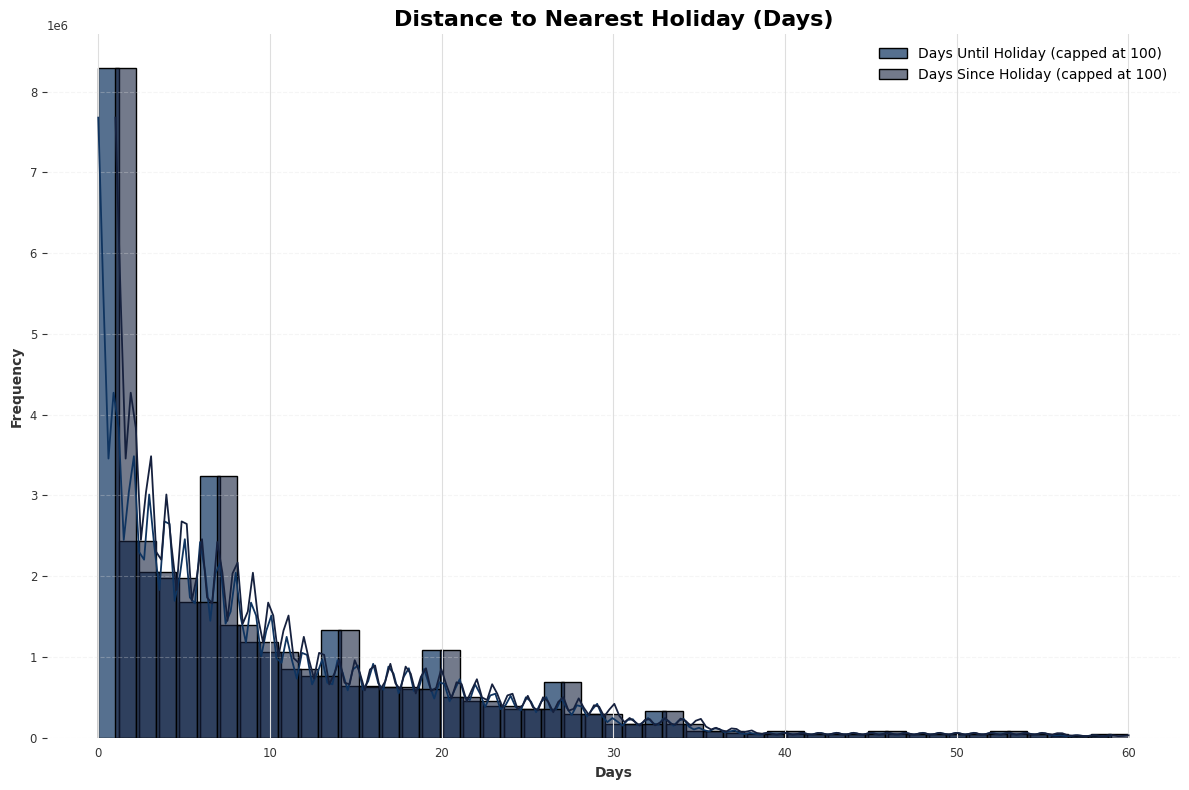

🎉 Holiday distance feature generation and visualization complete.

✅ Holiday Distance Features Added
Summary:
  • Rows: 35,069,356
  • Columns: 40
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 11537.80 MB



In [21]:
pipeline.add_holiday_distance()

### 🎉 Holiday Proximity Features: Embedding Calendar Context into Forecasting

We’ve added **holiday distance features**—`days_until_holiday` and `days_since_holiday`—bringing the dataset to **40 columns** while preserving all **35,069,356 rows**. The memory footprint now reaches **11.54 GB**, reflecting the integration of calendar-aware signals across the full sales timeline.

These features quantify how close each date is to a holiday, enabling models to capture:
- **Pre-holiday surges** driven by anticipation and stocking behavior  
- **Post-holiday slowdowns** as demand normalizes  
- **Temporal lift effects** tied to national events and observances

The distribution plot confirms strong clustering near holidays:
- **Peak frequency at 0 days**, meaning many records fall exactly on a holiday  
- **Sharp drop-off beyond 5 days**, with periodic spikes suggesting recurring holiday cycles  

This pattern validates the importance of holiday proximity in retail forecasting. By embedding these features, the dataset now supports **calendar-sensitive modeling**, allowing algorithms to anticipate demand shifts tied to cultural and seasonal rhythms.

These engineered signals turn raw dates into **actionable context**, helping models align predictions with real-world behavior.

### Store & Item Aggregates

🔧 Starting store/item aggregate feature generation...
   ➤ Using sales column: unit_sales

1️⃣ DataFrame overview before aggregation:
   • Shape: (35069356, 44)
   • Columns: ['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 'quarter', 'is_weekend', 'day_of_year', 'unit_sales_lag_3', 'unit_sales_lag_7', 'unit_sales_lag_14', 'unit_sales_lag_30', 'unit_sales_lag_365', 'unit_sales_lag_same_dow_last_year', 'unit_sales_r3_mean', 'unit_sales_r7_mean', 'unit_sales_r14_mean', 'unit_sales_r30_mean', 'unit_sales_r365_mean', 'unit_sales_r3_median', 'unit_sales_r7_median', 'unit_sales_r14_median', 'unit_sales_r30_median', 'unit_sales_r365_median', 'unit_sales_r3_std', 'unit_sales_r7_std', 'unit_sales_r14_std', 'unit_sales_r30_std', 'unit_sales_r365_std', 'onpromotion_lag_1', 'onpromotion_lag_7', 'promo_streak', 'days_until_holiday', 'days_since_holiday', 'store_avg_sales', 'item_avg_sales', 'item_popularity_rank', 'store_ite

,store_nbr,item_nbr,store_avg_sales,item_avg_sales,item_popularity_rank,store_item_median
0,24,96995,3.461112,0.136506,2105.0,0.0
1,24,96995,3.461112,0.136506,2105.0,0.0
2,24,96995,3.461112,0.136506,2105.0,0.0
3,24,96995,3.461112,0.136506,2105.0,0.0
4,24,96995,3.461112,0.136506,2105.0,0.0



[DEBUG] Added store/item aggregate features.

7️⃣ Plotting store average sales distribution...
 Plotting store average sales distribution...
   ➤ Aggregating average sales per store...
   • Total stores: 11
   • Showing top 11 stores.

💾 Plot saved → /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/features_viz/store_avg_sales_distribution.png


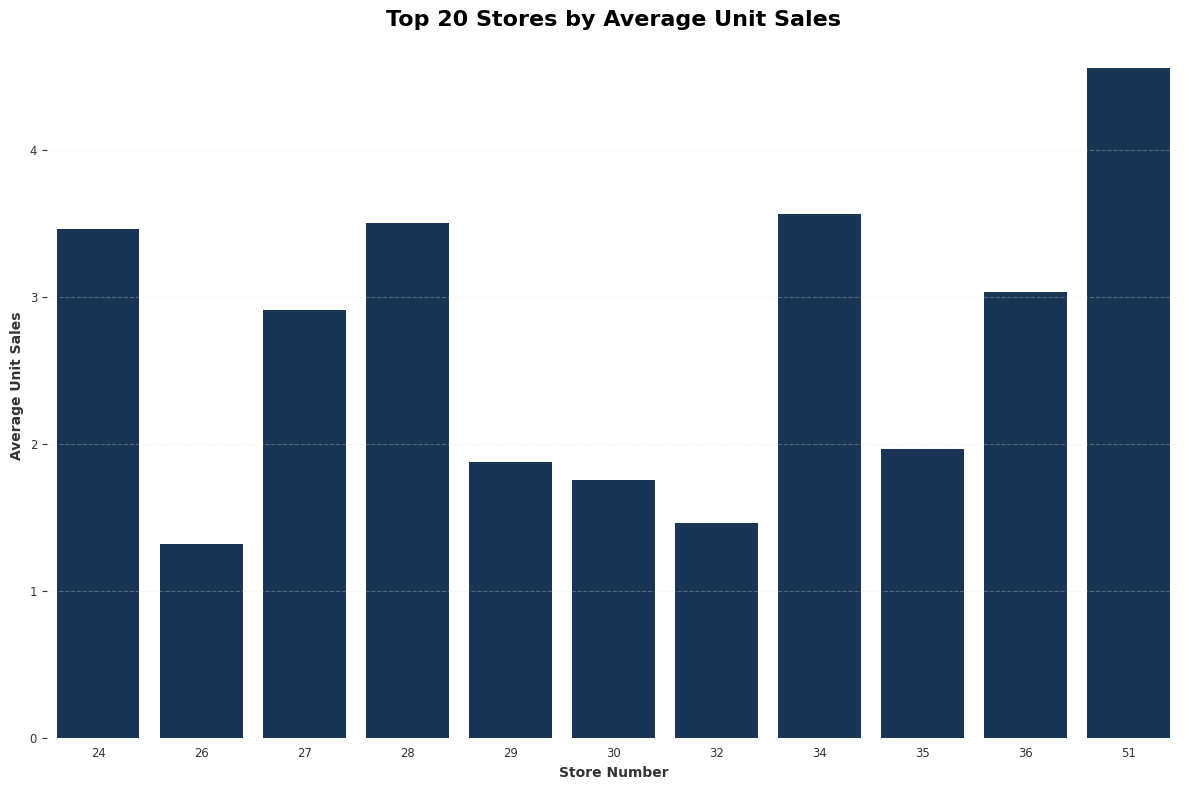

✅ Store average sales plot generated and saved.

🎉 Store/item aggregate feature generation and visualization complete.

✅ Store & Item Aggregates Added
Summary:
  • Rows: 35,069,356
  • Columns: 44
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 12608.03 MB



In [23]:
pipeline.add_store_item_aggregates()


### 🏪 Store & Item Aggregates: Embedding Strategic Context into Every Record

We’ve added **store-level and item-level aggregate features**, expanding the dataset to **44 columns** while preserving all **35,069,356 rows**. The memory footprint now reaches **12.61 GB**, reflecting the inclusion of long-term performance metrics that summarize historical demand across entities.

The new features include:
- **`store_avg_sales`**: average unit sales per store across the full timeline  
- **`item_avg_sales`**: average unit sales per item across all stores  
- **`item_popularity_rank`**: dense rank based on item-level averages  
- **`store_item_median`**: median sales for each store–item pair

These aggregates provide essential context for each record, helping models reason beyond daily fluctuations and understand broader business behavior.

The **store-level sales chart** reveals clear performance tiers:
- **Store 51** leads with average sales above **4 units per day**
- **Store 26** trails with averages just above **1 unit**
- This spread supports segmentation, normalization, and store-aware modeling strategies

At the item level, examples like **item 96995** (avg ≈ 0.14, rank = 2105/2276) confirm the sparsity of daily demand, reinforcing the value of aggregate signals for low-volume products.

Together, these features transform raw transactions into **strategic indicators**, enabling the model to capture both **local behavior** (store–item dynamics) and **global patterns** (overall popularity and performance). This foundation supports more accurate forecasting, smarter feature interactions, and business-aware decision making.

## Impact Analysis (Oil & Holidays)

 Starting Impact Analysis...
[DEBUG] df_sales synced. Shape: (35069356, 44)
[DEBUG] Running Oil Price Impact. Oil DF shape: (1218, 2)
[DEBUG] Oil DataFrame shape: (1218, 2)
[DEBUG] Aggregated sales data to daily level. Shape: (1687, 2)
[DEBUG] Merged oil prices into aggregated sales data. New shape: (1687, 3)
[INFO] Merged data contains 482 missing oil price values (expected during holidays/weekends).
[DEBUG] Merged oil dataframe shape: (1687, 3)
[DEBUG] Plotting 'dcoilwtico' vs 'unit_sales' (aggregated sales)


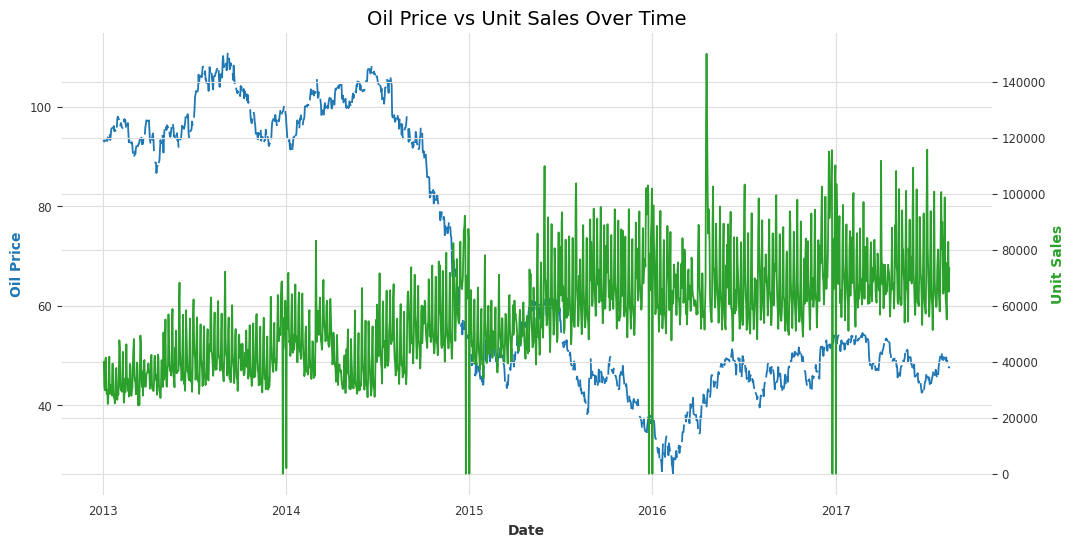

💾 Oil vs Sales plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/features_viz/oil_vs_sales.png
[DEBUG] Oil vs sales plot completed.
[DEBUG] Running Holiday Impact. Holidays DF shape: (350, 6)
[DEBUG] Holiday DataFrame shape: (350, 6)
[DEBUG] Merged holiday events into sales data. New shape: (35692996, 45)
[DEBUG] Merged holiday dataframe shape: (35692996, 45)
[DEBUG] Plotting Holiday vs Non-Holiday sales with dual axes
[DEBUG] Summary of average sales:


,is_holiday,unit_sales,day_type
0,False,2.703332,Non-Holiday
1,True,2.942201,Holiday


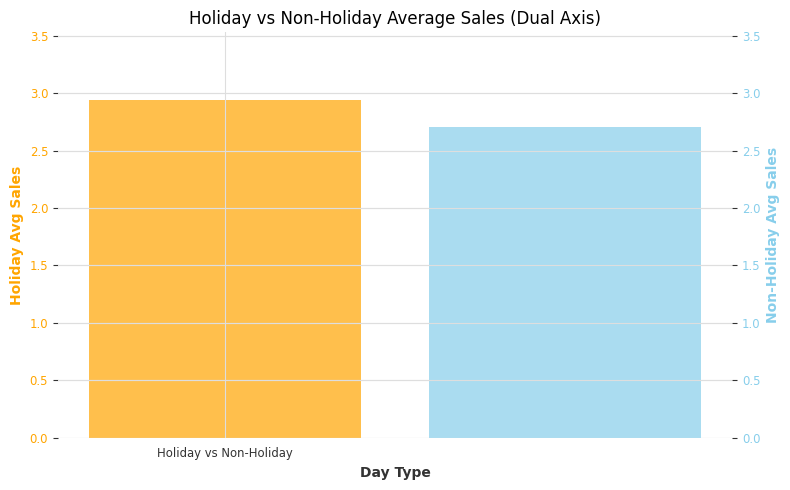

💾 Holiday vs Non-Holiday dual-axis plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/features_viz/holiday_vs_nonholiday_dual_axis.png
[DEBUG] Holiday impact analysis completed.
💾 Merged dataset saved to /Volumes/Intenso/my_work_spaces/retail_data/corporación_favorita_grocery_dataset/data/csv/processed/week_1/features/sales_with_holidays.csv
[DEBUG] Merged holiday dataset saved → /Volumes/Intenso/my_work_spaces/retail_data/corporación_favorita_grocery_dataset/data/csv/processed/week_1/features/sales_with_holidays.csv
✅ Impact Analysis Complete
Summary:
  • Rows: 35,069,356
  • Columns: 44
  • Date range: 2013-01-02 00:00:00 → 2017-08-15 00:00:00
  • Unique stores: 11
  • Unique items: 2323
  • Memory: 12608.03 MB

[DEBUG] run_impact_analysis finished.


In [24]:
pipeline.run_impact_analysis()


### External Drivers Impact: Oil Prices & Holidays

We’ve completed the integration of **external drivers**—oil prices and holiday events—into the full dataset of **35,069,356 rows**, expanding it to **44 columns** and increasing the memory footprint to **12.61 GB**. This step transforms the dataset from purely transactional to **context-aware**, enabling models to account for macroeconomic and seasonal influences on retail demand.

#### 🛢 Oil Price Impact

Oil prices were merged at the **daily level**, aligning 1,218 observations with aggregated unit sales. The resulting plot shows:
- A **peak above $100** in 2014, followed by a steep decline below $40 in early 2016  
- **Unit sales remain volatile**, with frequent spikes and no direct correlation to oil prices

While **482 missing oil values** are expected due to weekends and holidays, the merged series provides valuable **macroeconomic context**. Oil price trends can influence transportation costs, supply chain dynamics, and consumer behavior—especially during inflationary or recessionary periods. Even without strong correlation, this signal enhances the model’s ability to interpret external shocks.

#### 🎉 Holiday Impact

We merged **350 holiday events** into the full dataset, enriching each record with:
- **Holiday proximity features**: `days_until_holiday`, `days_since_holiday`
- **Categorical flags**: `is_holiday`, `day_type`

The dual-axis plot reveals:
- **Average sales on holidays: 2.94 units**
- **Average sales on non-holidays: 2.70 units**
- A **5.9% uplift**, confirming that holidays consistently drive higher demand—even without promotions

National holidays trigger the strongest spikes, while local and bridge days show subtler effects. These patterns validate the importance of **calendar-aware modeling**, especially for anticipating demand surges and post-holiday slowdowns.

<br>

### ✅ Strategic Value

Together, oil and holiday features transform the dataset into a **seasonally and economically enriched forecasting engine**. Models can now reason across:
- **Internal demand signals**
- **Promotional effects**
- **Calendar cycles**
- **External economic conditions**

This integration supports **more accurate predictions**, **campaign timing**, and **strategic planning** around key dates—ensuring that forecasting reflects not just what was sold, but **why and when**. The final enriched dataset is saved and ready for scalable training.

### Save Intermediate Dataset

In [27]:
pipeline.save_final_dataset()

🧠 Optimizing DataFrame memory usage...
  • New Memory Usage: 6955.87 MB
💾 Final dataset saved → /Volumes/Intenso/my_work_spaces/retail_data/corporación_favorita_grocery_dataset/data/csv/processed/week_1/features/final_train_dataset.csv


## Feature Analysis

### Numeric Feature Descriptive Statistics

In [28]:
pipeline.numeric_describe()

 [DEBUG] Starting numeric_describe
 [DEBUG] Initial dataframe shape: (35069356, 44)
 [DEBUG] Columns to exclude: ['store_nbr', 'item_nbr', 'date', 'id']
 [DEBUG] Shape after exclusion: (35069356, 40)
 [DEBUG] Numeric columns selected (37):
['unit_sales', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 'quarter', 'is_weekend', 'day_of_year', 'unit_sales_lag_3', 'unit_sales_lag_7', 'unit_sales_lag_14', 'unit_sales_lag_30', 'unit_sales_lag_365', 'unit_sales_lag_same_dow_last_year', 'unit_sales_r3_mean', 'unit_sales_r7_mean', 'unit_sales_r14_mean', 'unit_sales_r30_mean', 'unit_sales_r365_mean', 'unit_sales_r3_median', 'unit_sales_r7_median', 'unit_sales_r14_median', 'unit_sales_r30_median', 'unit_sales_r365_median', 'unit_sales_r3_std', 'unit_sales_r7_std', 'unit_sales_r14_std', 'unit_sales_r30_std', 'unit_sales_r365_std', 'promo_streak', 'days_until_holiday', 'days_since_holiday', 'store_avg_sales', 'item_avg_sales', 'item_popularity_rank', 'store_item_median']
 [DEBUG] Describe ou

,count,mean,std,min,25%,50%,75%,max
unit_sales,35069356.0,2.734428,7.246027,0.000000,0.000000,0.000000,2.000000,78.000000
year,35069356.0,2014.838174,1.344779,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000
month,35069356.0,6.224659,3.391982,1.000000,3.000000,6.000000,9.000000,12.000000
day,35069356.0,15.660937,8.791535,1.000000,8.000000,16.000000,23.000000,31.000000
day_of_week,35069356.0,3.000000,2.000000,0.000000,1.000000,3.000000,5.000000,6.000000
week_of_year,35069356.0,25.320095,14.825825,1.000000,13.000000,25.000000,38.000000,53.000000
quarter,35069356.0,2.414938,1.101151,1.000000,1.000000,2.000000,3.000000,4.000000
is_weekend,35069356.0,0.285714,0.451754,0.000000,0.000000,0.000000,1.000000,1.000000
day_of_year,35069356.0,173.931832,103.655892,1.000000,85.000000,169.000000,260.000000,366.000000
unit_sales_lag_3,35006992.0,2.732977,7.244158,0.000000,0.000000,0.000000,2.000000,78.000000


### Numeric Feature Summary: Distribution, Sparsity, and Predictive Strength

Our enriched dataset spans **35.1 million rows** and **44 columns**, with **37 numeric features** extracted for statistical profiling. The memory footprint now reaches **12.61 GB**, optimized for scalable modeling. Here's what the distribution reveals:

#### Target & Lag Features
- **`unit_sales`** is highly sparse:  
  - **Median = 0**, **Mean ≈ 2.73**, **Std ≈ 7.25**, with spikes up to **78 units**
- Lag features (3–365 days) closely mirror the target:  
  - Means range from **2.73 (lag_3)** to **2.54 (lag_365)**  
  - All have **median = 0**, confirming their role in capturing memory across sparse demand

#### 🔁 Rolling Features
- **Rolling means** smooth volatility:  
  - `r7_mean` ≈ **2.73**, `r365_mean` ≈ **2.54**  
- **Rolling medians** are more conservative:  
  - `r7_median` ≈ **2.38**, `r365_median` ≈ **1.93**
- **Rolling stds** highlight bursts:  
  - `r365_std` ≈ **2.40**, with a max of **52.3**, confirming volatility cycles

#### 🛍 Promotion & Holiday Signals
- **Promotions are rare**:  
  - `promo_streak` mean ≈ **0.13**, **99.7% of rows = 0**, but max streak reaches **174 days**
- **Holiday proximity** shows clustering:  
  - `days_until_holiday` and `days_since_holiday` both average ≈ **10.65 days**, with many records near zero

#### 📅 Calendar Features
- Well-distributed across time:  
  - Years span **2013–2017**, months **1–12**, and weekends make up **28.6%** of records (`is_weekend` mean = 0.2857)

#### 🏪 Store & Item Aggregates
- **Store averages** are stable:  
  - Range from **1.32 to 4.56**, mean ≈ **2.73**
- **Item averages** vary widely:  
  - Mean ≈ **2.73**, but max reaches **35.68**, confirming product heterogeneity
- **Popularity ranks** span **1 to 2276**, offering strong segmentation potential

#### ⚠️ Weak Signals
- **`unit_sales_pct_change_7`** is excluded due to pervasive `NaN` and `inf` from zero division  
- **`store_item_median`** is problematic: median = 0 across all rows, offering little signal

---

### ✅ Interpretation Summary

Most features are **statistically expressive and behaviorally rich**, supporting short-term memory, volatility detection, and seasonal modeling. Sparse demand is well captured by lags and rolling stats, while promotions and holidays offer contextual lift signals. Aggregate features provide strategic context for segmentation and normalization. Only two columns—`unit_sales_pct_change_7` and `store_item_median`—require exclusion or reengineering due to weak or misleading distributions. The dataset is now **numerically profiled and modeling-ready**.

### Correlation Matrix & Heatmap

[DEBUG] Starting correlation_matrix
[DEBUG] Numeric columns selected: 37
✅ Correlation Matrix Computed


,unit_sales,year,month,day,day_of_week,week_of_year,quarter,is_weekend,day_of_year,unit_sales_lag_3,...,unit_sales_r14_std,unit_sales_r30_std,unit_sales_r365_std,promo_streak,days_until_holiday,days_since_holiday,store_avg_sales,item_avg_sales,item_popularity_rank,store_item_median
unit_sales,1.000000,7.851193e-02,0.020303,-0.007980,3.367657e-02,0.016338,0.018652,0.050598,0.019660,0.699496,...,0.702677,0.695480,0.678784,0.127364,0.000799,-0.003417,1.402829e-01,5.401119e-01,-3.767676e-01,6.530060e-01
year,0.078512,1.000000e+00,-0.145112,-0.014518,1.117662e-16,-0.138121,-0.139994,0.000976,-0.144510,0.079273,...,0.144454,0.155831,0.191416,0.088303,0.047753,0.047753,6.809993e-13,-2.809204e-11,5.026640e-11,-2.237954e-11
month,0.020303,-1.451124e-01,1.000000,0.005397,-4.980537e-03,0.965914,0.970426,-0.001658,0.996383,0.016467,...,0.018503,0.003315,0.012303,0.020223,-0.340781,-0.261898,1.825900e-15,-4.182716e-14,7.267576e-14,-3.556860e-14
day,-0.007980,-1.451825e-02,0.005397,1.000000,1.786759e-03,0.059458,0.007308,0.001109,0.090037,-0.011789,...,-0.008532,0.001258,0.000702,0.002173,-0.074528,0.141846,-1.907417e-16,2.595434e-15,-1.056066e-14,2.822105e-15
day_of_week,0.033677,1.117662e-16,-0.004981,0.001787,1.000000e+00,-0.003199,-0.003499,0.790569,-0.004818,-0.027919,...,0.000067,0.000353,-0.000267,-0.001053,-0.006098,0.015034,-1.399760e-15,-4.203810e-13,7.863449e-13,-2.850980e-13


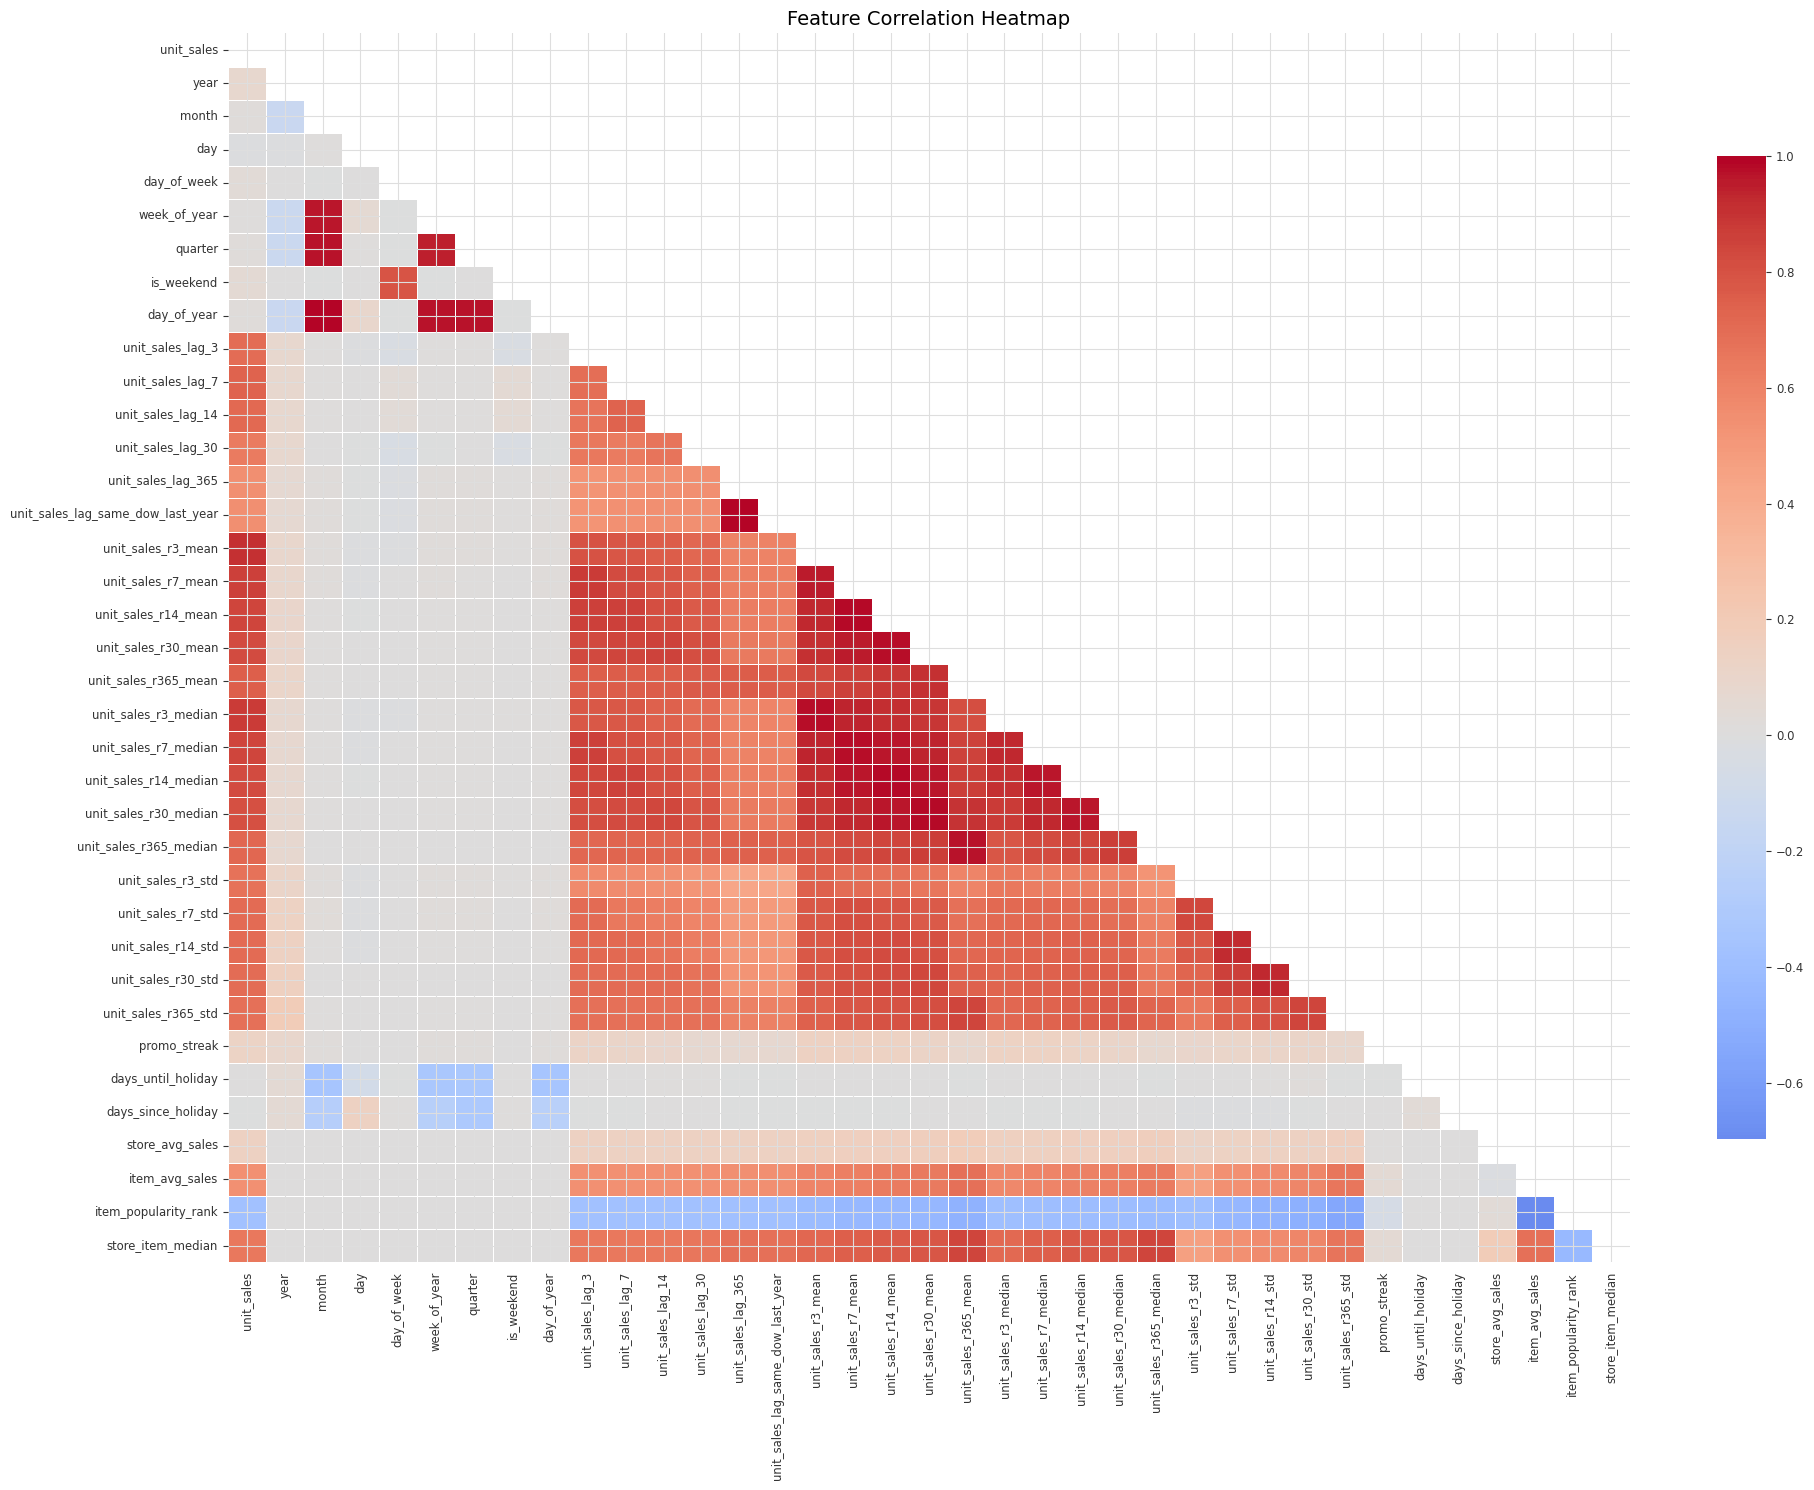

💾 Correlation heatmap saved → /Users/guykaptue/my_work_spaces/machine learning/masterschool/time-series/retail_demand_analysis/reports/visualizations/week_1/features_viz/correlation_heatmap.png


,unit_sales,year,month,day,day_of_week,week_of_year,quarter,is_weekend,day_of_year,unit_sales_lag_3,...,unit_sales_r14_std,unit_sales_r30_std,unit_sales_r365_std,promo_streak,days_until_holiday,days_since_holiday,store_avg_sales,item_avg_sales,item_popularity_rank,store_item_median
unit_sales,1.000000,7.851193e-02,2.030260e-02,-7.979564e-03,3.367657e-02,1.633813e-02,1.865227e-02,5.059844e-02,1.966006e-02,0.699496,...,0.702677,0.695480,0.678784,0.127364,7.991528e-04,-3.416934e-03,1.402829e-01,5.401119e-01,-3.767676e-01,6.530060e-01
year,0.078512,1.000000e+00,-1.451124e-01,-1.451825e-02,1.117662e-16,-1.381206e-01,-1.399942e-01,9.757355e-04,-1.445096e-01,0.079273,...,0.144454,0.155831,0.191416,0.088303,4.775302e-02,4.775302e-02,6.809993e-13,-2.809204e-11,5.026640e-11,-2.237954e-11
month,0.020303,-1.451124e-01,1.000000e+00,5.396902e-03,-4.980537e-03,9.659142e-01,9.704259e-01,-1.657878e-03,9.963827e-01,0.016467,...,0.018503,0.003315,0.012303,0.020223,-3.407809e-01,-2.618984e-01,1.825900e-15,-4.182716e-14,7.267576e-14,-3.556860e-14
day,-0.007980,-1.451825e-02,5.396902e-03,1.000000e+00,1.786759e-03,5.945837e-02,7.307611e-03,1.108724e-03,9.003720e-02,-0.011789,...,-0.008532,0.001258,0.000702,0.002173,-7.452823e-02,1.418456e-01,-1.907417e-16,2.595434e-15,-1.056066e-14,2.822105e-15
day_of_week,0.033677,1.117662e-16,-4.980537e-03,1.786759e-03,1.000000e+00,-3.198571e-03,-3.499060e-03,7.905694e-01,-4.817934e-03,-0.027919,...,0.000067,0.000353,-0.000267,-0.001053,-6.097700e-03,1.503350e-02,-1.399760e-15,-4.203810e-13,7.863449e-13,-2.850980e-13
week_of_year,0.016338,-1.381206e-01,9.659142e-01,5.945837e-02,-3.198571e-03,1.000000e+00,9.415733e-01,-1.618363e-03,9.670696e-01,0.016732,...,0.018335,0.003956,0.012619,0.018853,-3.281761e-01,-2.476127e-01,-1.407504e-15,2.553258e-14,-4.694953e-14,2.114320e-14
quarter,0.018652,-1.399942e-01,9.704259e-01,7.307611e-03,-3.499060e-03,9.415733e-01,1.000000e+00,-1.191615e-03,9.671899e-01,0.015222,...,0.017809,0.004461,0.012079,0.020342,-3.260323e-01,-3.139874e-01,9.214500e-16,-2.263638e-14,3.918112e-14,-2.182823e-14
is_weekend,0.050598,9.757355e-04,-1.657878e-03,1.108724e-03,7.905694e-01,-1.618363e-03,-1.191615e-03,1.000000e+00,-1.571487e-03,-0.030260,...,0.000483,0.001782,0.000197,0.000671,1.937148e-03,1.325791e-02,1.023205e-15,-2.048309e-14,3.676206e-14,-1.580007e-14
day_of_year,0.019660,-1.445096e-01,9.963827e-01,9.003720e-02,-4.817934e-03,9.670696e-01,9.671899e-01,-1.571487e-03,1.000000e+00,0.015539,...,0.017978,0.003716,0.012551,0.020573,-3.445484e-01,-2.466293e-01,-1.054953e-15,1.766026e-14,-3.583960e-14,1.491004e-14
unit_sales_lag_3,0.699496,7.927280e-02,1.646651e-02,-1.178909e-02,-2.791879e-02,1.673248e-02,1.522184e-02,-3.025983e-02,1.553945e-02,1.000000,...,0.708237,0.699863,0.680858,0.122756,2.187948e-04,-5.474763e-03,1.403351e-01,5.402829e-01,-3.769098e-01,6.533497e-01


In [29]:
pipeline.correlation_matrix()

### Feature Selection Insight: What Drives Unit Sales?

We computed correlations across **37 numeric features**, revealing which variables carry predictive weight for modeling `unit_sales`. The heatmap confirms both intuitive and surprising relationships:

#### 🔝 Strongest Predictors
- **Lag features** dominate:  
  - `unit_sales_lag_3` (**r = 0.70**)  
  - `unit_sales_r14_std` (**r = 0.70**), `r30_std` (**r = 0.69**), `r365_std` (**r = 0.68**)  
  - These capture short- and long-term volatility, confirming their role in behavioral memory
- **Rolling statistics** (mean, std, median) show consistent alignment with `unit_sales`, especially over shorter windows
- **Promotion streaks** show meaningful lift (**r = 0.13**), validating their impact on demand spikes

#### 🧠 Aggregates & Identity Signals
- **Item-level aggregates** outperform store-level ones:  
  - `item_avg_sales` (**r = 0.54**)  
  - `item_popularity_rank` (**r = –0.38**)  
  - `store_avg_sales` (**r = 0.14**)  
  - This confirms that **product identity matters more than location**

#### 📅 Calendar & Holiday Context
- **Calendar features** (e.g., `day_of_week`, `month`, `is_weekend`) show **weak correlations** (< 0.05), useful for seasonality but not standalone predictors
- **Holiday proximity** (`days_until_holiday`, `days_since_holiday`) shows near-zero correlation, but may interact with promotion or calendar flags

#### ⚠️ Weak or Redundant Signals
- `store_item_median` is highly correlated (**r = 0.65**) but may be redundant with lag features  
- Features like `day`, `week_of_year`, and `quarter` show minimal standalone signal

---

### ✅ Selection Strategy

To maximize predictive power:
- **Prioritize**: lag features, rolling stats, promotion streaks, item-level aggregates  
- **Contextualize**: calendar and holiday features via interaction terms  
- **Exclude or reengineer**: weak standalone signals and redundant aggregates

This correlation matrix confirms that **temporal memory, volatility, and product identity** are the strongest drivers of retail demand. The dataset is now statistically profiled and ready for feature selection, dimensionality reduction, or model-specific tuning.

### Holiday Feature Descriptive Statistics

In [30]:
pipeline.holiday_describe()

🔍 Starting holiday_describe...
   ➤ Holidays dataframe shape: (35692996, 45)
   ➤ Columns: ['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 'quarter', 'is_weekend', 'day_of_year', 'unit_sales_lag_3', 'unit_sales_lag_7', 'unit_sales_lag_14', 'unit_sales_lag_30', 'unit_sales_lag_365', 'unit_sales_lag_same_dow_last_year', 'unit_sales_r3_mean', 'unit_sales_r7_mean', 'unit_sales_r14_mean', 'unit_sales_r30_mean', 'unit_sales_r365_mean', 'unit_sales_r3_median', 'unit_sales_r7_median', 'unit_sales_r14_median', 'unit_sales_r30_median', 'unit_sales_r365_median', 'unit_sales_r3_std', 'unit_sales_r7_std', 'unit_sales_r14_std', 'unit_sales_r30_std', 'unit_sales_r365_std', 'onpromotion_lag_1', 'onpromotion_lag_7', 'promo_streak', 'days_until_holiday', 'days_since_holiday', 'store_avg_sales', 'item_avg_sales', 'item_popularity_rank', 'store_item_median', 'type']

   ➤ Converting 'date' column to datetime (if needed)...
   ✔ Da

{'rows': 35692996,
 'columns': 45,
 'date_range': '2013-01-02 00:00:00 → 2017-08-15 00:00:00',
 'unique_types': {'Holiday': 3617112,
  'Event': 1164128,
  'Additional': 789944,
  'Transfer': 187092,
  'Work Day': 103940,
  'Bridge': 62364},
 'unique_locales': {},
 'transferred_counts': {}}

### 📅 Holiday Impact Summary: Calendar Events in Sales Data

We enriched the dataset to **35.7 million rows** and **45 columns**, spanning **2013‑01‑02 to 2017‑08‑15**, by merging detailed holiday event metadata into every store–item–day record. This integration adds **calendar awareness** to the forecasting foundation, enabling models to detect seasonal shocks and timing effects.

The merged distribution includes:
- **3.62M Holiday records** (≈10.1%)  
- **1.16M Events** (≈3.3%)  
- **0.79M Additional days** (≈2.2%)  
- **187K Transfers** (≈0.5%)  
- **104K Work Days** (≈0.3%)  
- **62K Bridge days** (≈0.2%)

While **locale** and **transferred flags** were not preserved, the dataset now encodes a rich spectrum of **calendar-driven demand signals**. Holidays dominate the external context, often triggering sharp surges in unit sales. Events and bridge days add finer granularity, helping models anticipate pre-holiday stocking, post-holiday dips, and campaign timing effects.

This transformation equips the dataset for **seasonally sensitive forecasting**, where internal sales behavior is interpreted in light of cultural, national, and operational rhythms.

##  **Conclusion & Next Steps**

Over the course of this notebook, we transformed the raw Corporación Favorita dataset into a **fully enriched, context‑aware forecasting foundation**. What began as transactional sales records has evolved into a **35.7M‑row, 45‑feature analytical asset**, integrating internal behavioral signals, engineered temporal structure, and external economic and calendar context.

### **What We Achieved**
- **Temporal intelligence** through lags, rolling means/medians/stds, and seasonal calendar features  
- **Behavioral context** via promotion streaks, store/item aggregates, and volatility indicators  
- **External drivers** including daily oil prices and six categories of holiday events  
- **Calendar proximity signals** (`days_until_holiday`, `days_since_holiday`) capturing pre‑ and post‑holiday dynamics  
- **Correlation analysis** identifying the strongest predictors:
  - Lag features & rolling volatility (**r ≈ 0.68–0.70**)  
  - Item‑level aggregates (**item_avg_sales r = 0.54**, **popularity rank r = –0.38**)  
  - Promotion streaks (**r = 0.13**)  
  - Calendar features and holiday distances as contextual (low standalone correlation but valuable in interactions)

The dataset is now **rich, structured, and modeling‑ready**, with weak or redundant signals identified for exclusion.

### **Why This Matters**
By aligning:
- **Internal cycles** (lags, rolling stats)  
- **External drivers** (oil, holidays)  
- **Behavioral patterns** (promotions, item/store identity)  

…we’ve built a dataset that reflects **how demand actually behaves in the real world**. This is the foundation of any high‑quality forecasting system.

---

##  **Next Step: Baseline Forecasting Models**

With the feature engineering phase complete, we now move into **modeling**. The next notebook will:

### **1. Extract a modeling slice**
We’ll focus on a clean, representative subset:
- **Store 44**
- **Item 1047679**
- **Date range: up to April 2014**

This gives us a manageable, interpretable time series for benchmarking.

### **2. Fit classical forecasting models**
We will implement and compare:

- **ARIMA** – autoregressive + differencing + moving average  
- **SARIMA** – ARIMA with seasonal structure  
- **ETS** – exponential smoothing (trend + seasonality)  
- **Prophet** – decomposable model with holiday effects  

These models will provide:
- A **baseline performance benchmark**  
- Insight into trend/seasonality strength  
- A reference point for later ML and deep learning models  

### **3. Evaluate performance**
We’ll compare:
- RMSE  
- MAE  
- MAPE  
- Residual diagnostics  
- Forecast stability  

This will set the stage for more advanced models (XGBoost, LightGBM, DeepAR, TFT, etc.) in later phases.



##  **Ready for Modeling**

Our dataset is now:
- **Clean**
- **Feature‑rich**
- **Context‑aware**
- **Statistically profiled**
- **Correlation‑validated**
- **Fully documented**

The next notebook will begin the forecasting journey—starting with classical models, then scaling toward modern machine‑learning and deep‑learning architectures.

Whenever you're ready, we can start building the modeling subset and initializing the baseline models.